In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle



In [4]:
model_df = pd.read_csv('model_df.csv')

Train Test Split

In [5]:
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values

    return train, test

train, test = tts(model_df)


In [6]:
train.shape

(35, 13)

In [7]:
test.shape

(12, 13)

In [8]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [9]:
y_train.shape

(35,)

Modeling Functions

In [10]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))

    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

In [12]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [13]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)

    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [14]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [15]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax,
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='Red')

    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")

    ax.legend()

    sns.despine()

    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [16]:
def run_model(train_data, test_data, model, model_name):

    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)

    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)

    get_scores(unscaled_df, original_df, model_name)

    plot_results(unscaled_df, original_df, model_name)

Linear Regression

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


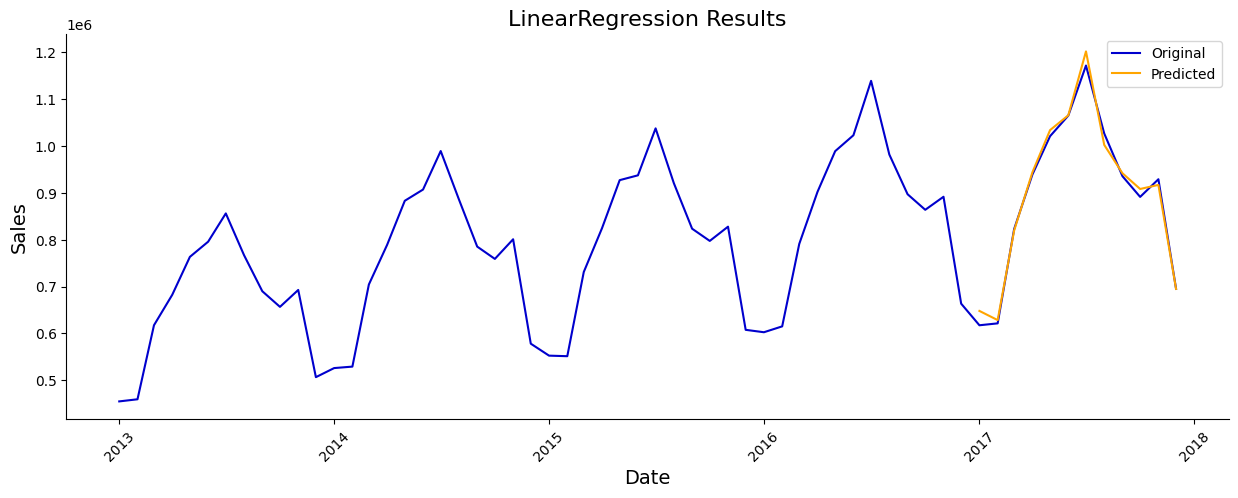

In [20]:
run_model(train, test, LinearRegression(), 'LinearRegression')


Random Forest Regressor

RMSE: 18514.827053832647
MAE: 15572.5
R2 Score: 0.9879041527956574


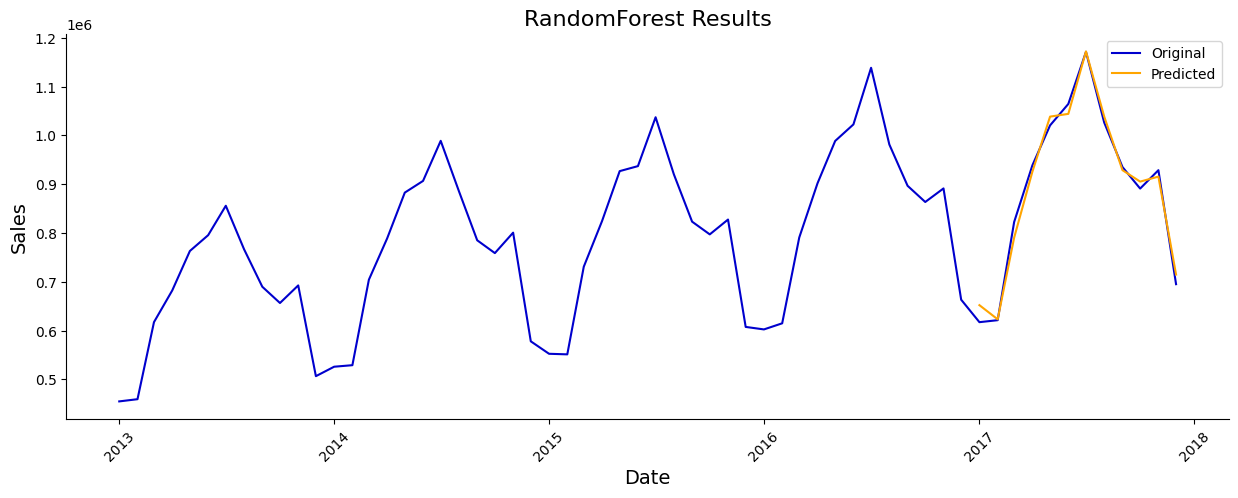

In [21]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20),
          'RandomForest')

XGBoost

RMSE: 25920.433602983314
MAE: 19914.833333333332
R2 Score: 0.9762927326532191


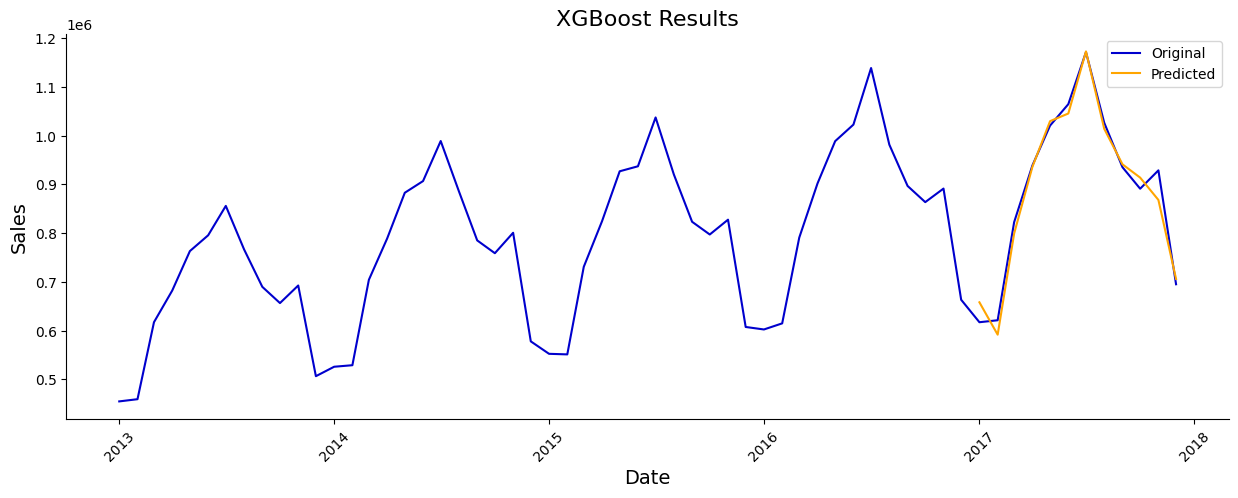

In [22]:
run_model(train, test, XGBRegressor( n_estimators=100,
                                    learning_rate=0.2,
                                    objective='reg:squarederror'), 'XGBoost')

LSTM(Without stateful LSTM (Remove stateful=True))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2753
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2488
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2277
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2083
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1903
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1735
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1577
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1430
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1291
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1162
Epoch 11/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1043
Epoch 12/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0932
Epoch 13/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0832
Epoch 14/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0740
Epoch 15/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658
Epoc

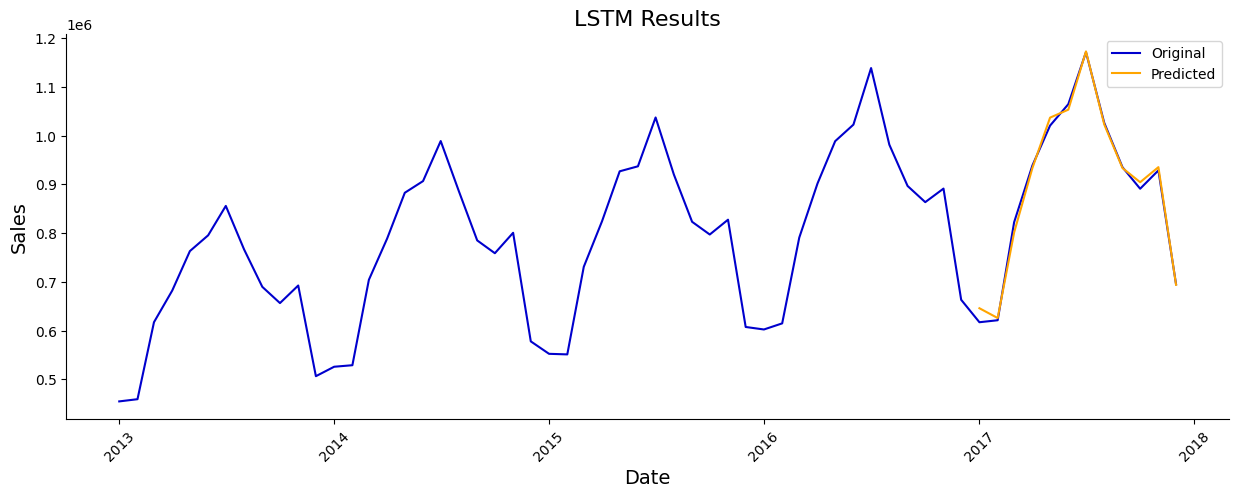

In [30]:
def lstm_model(train_data, test_data):
    # Scaling the data
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    # Reshape the data for LSTM
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Define the model
    model = Sequential()

    # Use input_shape instead of batch_input_shape
    model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))

    # Output layer
    model.add(Dense(1))  # Only one Dense layer for output

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False)

    # Make predictions
    predictions = model.predict(X_test, batch_size=1)

    # Undo scaling of predictions (use appropriate method for this)
    original_df = load_original_df()  # Assuming it loads the original data
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)

    # Create DataFrame of unscaled predictions
    unscaled_df = predict_df(unscaled, original_df)

    # Calculate performance scores (e.g., RMSE, MAE)
    get_scores(unscaled_df, original_df, 'LSTM')

    # Plot the results
    plot_results(unscaled_df, original_df, 'LSTM')

# Call the LSTM model function with train and test data
lstm_model(train, test)


In [31]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )